# NON LOCAL MEANS

In [2]:
import numpy as np
import cv2
from skimage import img_as_float
import matplotlib.pyplot as plt

## Utils

In [3]:
def compare_results(A, B):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(A)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Result")
    plt.imshow(B)
    plt.axis("off")

    plt.show()

## CV2 fast NLM

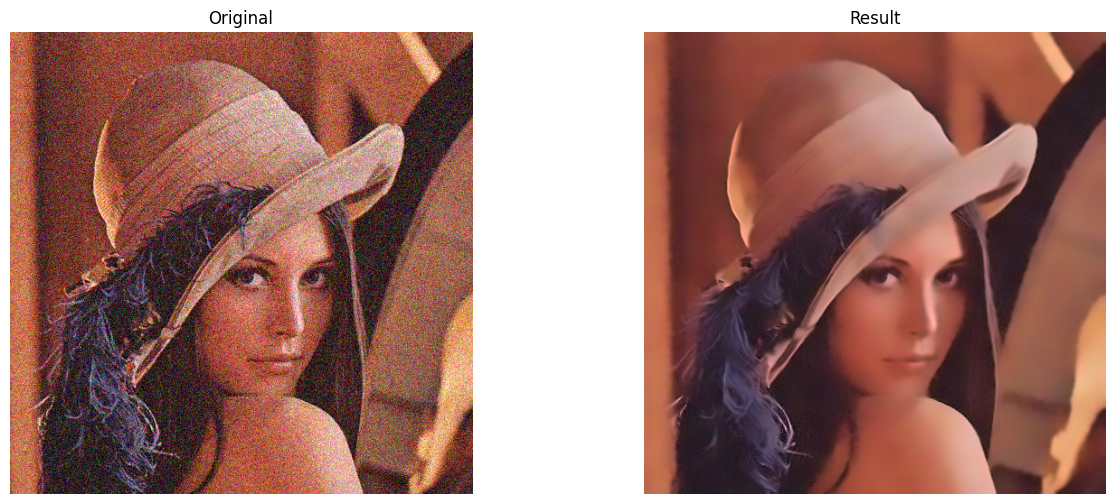

In [14]:
image = cv2.imread("src/base_lena_bruit.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR to RGB

image_denoised = cv2.fastNlMeansDenoisingColored(image_rgb, None, 25, 25, 7, 21)

compare_results(image_rgb, image_denoised)

## Our own NLM

In [6]:
def custom_NlMeansDenoisingColored(image: np.array,
                                   patch_size: int = 3,
                                   search_window_size: int = 21,
                                   h: int = 10):
    """Denoise RGB image with non local means

    Args:
        image (np.array): RGB image
        patch_size (int, optional): Size of sub-images to compare with others. Defaults to 3 -> matrix 3*3
        search_window_size (int, optional): search area. Defaults to 21.
        h (int, optional): intensity of the filter. Low = keep details, High = no details
    """
    image = img_as_float(image)  # float pour des calculs plus precis

    denoised = np.zeros_like(image)  # new image, same shape but only 0
    
    pad_size = search_window_size // 2  # fenetre de recherche
    patch_radius = patch_size // 2
    padded_image = np.pad(image,
                          ((pad_size, pad_size),
                           (pad_size, pad_size),
                           (0, 0)),
                           "reflect")
    
    # gauss
    gaussian_kernel = np.exp(
        -0.5
        * (np.linspace(-patch_radius, patch_radius, patch_size) ** 2)
        / (h ** 2))
    gaussian_kernel = gaussian_kernel[:, None] * gaussian_kernel[None, :]
    
    # patches extraction
    patches = np.lib.stride_tricks.as_strided(
        padded_image,
        shape=(padded_image.shape[0] - patch_size + 1,
               padded_image.shape[1] - patch_size + 1,
               patch_size,
               patch_size,
               image.shape[2]),
        strides=padded_image.strides[:2] + padded_image.strides[:2] + padded_image.strides[2:]
    )
    
    # original image, loop sur chaque pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # coords du pixel au centre des recherches
            i1 = i + pad_size
            j1 = j + pad_size
            
            # define search limits, borders
            ref_patch = padded_image[i1-patch_radius:i1+patch_radius+1,
                                     j1-patch_radius:j1+patch_radius+1, :]

            i_min = max(i1 - pad_size, 0)
            i_max = min(i1 + pad_size + 1, padded_image.shape[0] - patch_size + 1)
            j_min = max(j1 - pad_size, 0)
            j_max = min(j1 + pad_size + 1, padded_image.shape[1] - patch_size + 1)
            
            # patches extraction
            search_window = patches[i_min:i_max, j_min:j_max]
            search_window = search_window.reshape(-1,
                                                  patch_size,
                                                  patch_size,
                                                  image.shape[2])
            
            # distance between ref patch and patch
            distances = np.sum(
                (search_window - ref_patch[None, :, :, :]) ** 2
                * gaussian_kernel[None, :, :, None],
                axis=(1, 2, 3))
            
            # weight by distances
            weights = np.exp(-distances / (h ** 2))
            weights /= np.sum(weights)
            
            # result
            denoised[i, j, :] = np.sum(weights[:, None] * search_window[:, patch_radius, patch_radius, :], axis=0)
    
    return denoised

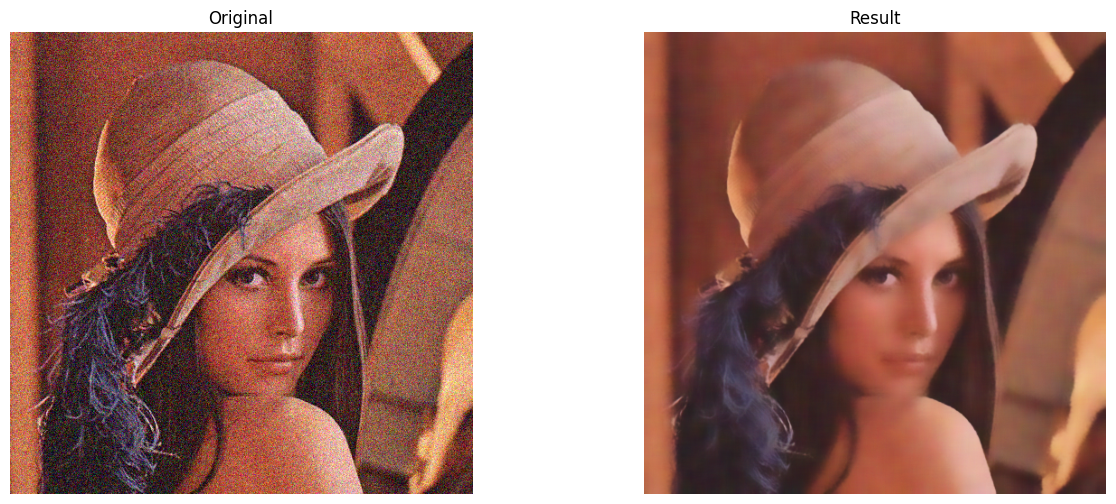

In [7]:
image = cv2.imread("src/lena_bruit.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_denoised = custom_NlMeansDenoisingColored(image_rgb, patch_size=5, search_window_size=15, h=1)

compare_results(image_rgb, image_denoised)

## Results

* **CV2 :** window 15, h 15 -> 0.9 seconds
* **Custom NLM :** patch 5, window 15, h 1 -> 38.1 seconds